# 7장. 자연어 처리를 위한 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

## RNN으로 텍스트 분류기 만들기

In [2]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [3]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [5]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [8]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,349,169
Trainable params: 1,349,169
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 18s 13ms/step - loss: 0.6889 - accuracy: 0.5602 - val_loss: 0.6843 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 9s 12ms/step - loss: 0.6834 - accuracy: 0.5596 - val_loss: 0.6792 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 9s 12ms/step - loss: 0.6792 - accuracy: 0.5596 - val_loss: 0.6743 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 9s 12ms/step - loss: 0.6726 - accuracy: 0.5597 - val_loss: 0.6661 - val_accuracy: 0.5708
Epoch 5/30
719/719 [==============================] - 9s 13ms/step - loss: 0.6592 - accuracy: 0.5858 - val_loss: 0.6475 - val_accuracy: 0.6317
Epoch 6/30
719/719 [==============================] - 9s 12ms/step - loss: 0.6311 - accuracy: 0.6703 - val_loss: 0.6175 - val_accuracy: 0.6759
Epoch 7/30
719/719 [==============================] - 9s 12ms/step - loss: 0.6007 - accuracy: 0.7008 - val_loss: 0.5938 - val_accuracy: 0.704

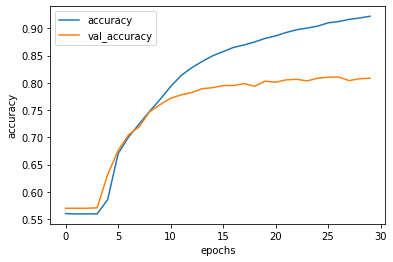

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

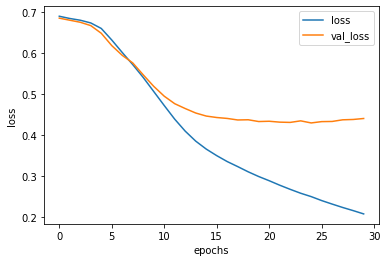

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 스태킹 LSTM

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,447,985
Trainable params: 1,447,985
No

In [16]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 21s 22ms/step - loss: 0.6876 - accuracy: 0.5596 - val_loss: 0.6820 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6833 - accuracy: 0.5596 - val_loss: 0.6793 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 15s 20ms/step - loss: 0.6792 - accuracy: 0.5596 - val_loss: 0.6726 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6610 - accuracy: 0.5931 - val_loss: 0.6382 - val_accuracy: 0.6697
Epoch 5/30
719/719 [==============================] - 15s 20ms/step - loss: 0.5896 - accuracy: 0.7015 - val_loss: 0.5579 - val_accuracy: 0.7177
Epoch 6/30
719/719 [==============================] - 14s 20ms/step - loss: 0.4824 - accuracy: 0.7731 - val_loss: 0.5010 - val_accuracy: 0.7587
Epoch 7/30
719/719 [==============================] - 15s 20ms/step - loss: 0.4113 - accuracy: 0.8149 - val_loss: 0.4861 - val_accuracy:

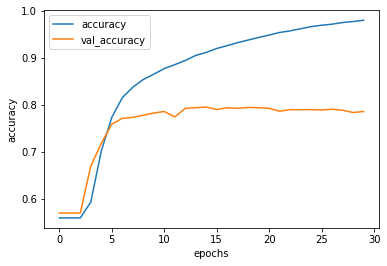

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

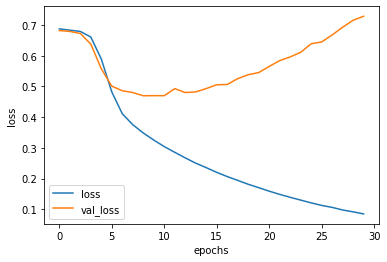

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 스태킹 LSTM 최적화하기

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [20]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 21s 22ms/step - loss: 0.6883 - accuracy: 0.5590 - val_loss: 0.6828 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 15s 20ms/step - loss: 0.6831 - accuracy: 0.5596 - val_loss: 0.6791 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 14s 20ms/step - loss: 0.6799 - accuracy: 0.5596 - val_loss: 0.6750 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 14s 20ms/step - loss: 0.6726 - accuracy: 0.5646 - val_loss: 0.6629 - val_accuracy: 0.6007
Epoch 5/30
719/719 [==============================] - 14s 20ms/step - loss: 0.6369 - accuracy: 0.6529 - val_loss: 0.6036 - val_accuracy: 0.6889
Epoch 6/30
719/719 [==============================] - 15s 20ms/step - loss: 0.5299 - accuracy: 0.7423 - val_loss: 0.5091 - val_accuracy: 0.7536
Epoch 7/30
719/719 [==============================] - 14s 20ms/step - loss: 0.4495 - accuracy: 0.7949 - val_loss: 0.4920 - val_accuracy:

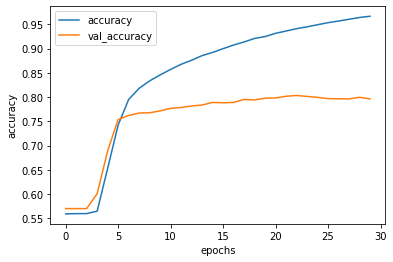

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

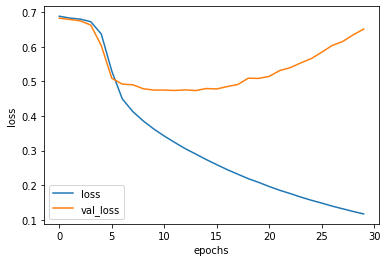

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 드롭아웃 사용하기

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        embedding_dim, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [24]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 21s 22ms/step - loss: 0.6897 - accuracy: 0.5490 - val_loss: 0.6847 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 15s 20ms/step - loss: 0.6848 - accuracy: 0.5596 - val_loss: 0.6810 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6816 - accuracy: 0.5596 - val_loss: 0.6770 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 15s 20ms/step - loss: 0.6752 - accuracy: 0.5599 - val_loss: 0.6666 - val_accuracy: 0.5713
Epoch 5/30
719/719 [==============================] - 15s 21ms/step - loss: 0.6427 - accuracy: 0.6299 - val_loss: 0.6048 - val_accuracy: 0.6870
Epoch 6/30
719/719 [==============================] - 15s 20ms/step - loss: 0.5482 - accuracy: 0.7253 - val_loss: 0.5241 - val_accuracy: 0.7366
Epoch 7/30
719/719 [==============================] - 15s 21ms/step - loss: 0.4837 - accuracy: 0.7703 - val_loss: 0.4995 - val_accuracy:

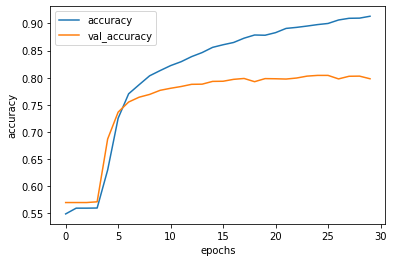

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

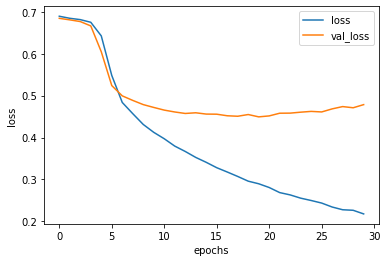

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## RNN에 사전 훈련된 임베딩 사용하기

In [27]:
!wget https://bit.ly/3i9taLA -O glove.zip

--2022-07-07 03:20:42--  https://bit.ly/3i9taLA
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip [following]
--2022-07-07 03:20:42--  https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip
Resolving tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)... 192.0.72.18, 192.0.72.19
Connecting to tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)|192.0.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109906941 (105M) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>] 104.81M  83.3MB/s    in 1.3s    

2022-07-07 03:20:44 (83.3 MB/s) - ‘glove.zip’ saved [109906941/109906941]



In [28]:
# GloVe 임베딩 압축 풀기
import os
import zipfile
local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [29]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [30]:
glove_embeddings['frog']

array([-1.2158  , -0.74924 ,  0.91941 ,  0.72985 , -0.12917 , -0.19555 ,
        1.2365  , -0.77196 ,  0.85161 ,  0.11922 ,  0.16816 ,  0.33334 ,
       -2.0845  , -0.53471 ,  0.013538,  0.18178 ,  1.2831  ,  0.089331,
        0.57264 ,  0.50694 ,  0.27134 ,  0.66504 ,  0.54097 , -0.58377 ,
        0.67097 ], dtype=float32)

In [31]:
vocab_size = 13200
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [32]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [34]:
xs=[]
ys=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
    xs.append(index)
    if glove_embeddings.get(word) is not None:
        total_y = total_y + 1
        ys.append(1)
    else:
        ys.append(0)
    cumulative_y.append(total_y / index)

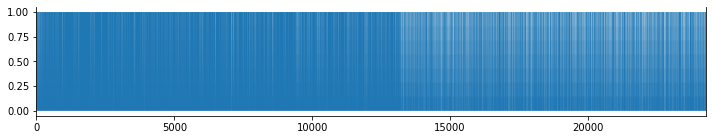

In [35]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)
plt.show()

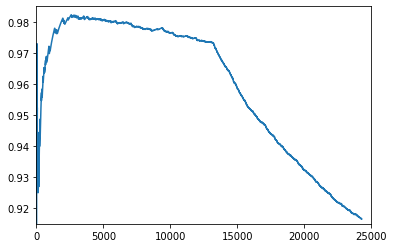

In [36]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985])
plt.show()

In [37]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [38]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [40]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 16s 16ms/step - loss: 0.6878 - accuracy: 0.5607 - val_loss: 0.6824 - val_accuracy: 0.5910
Epoch 2/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6773 - accuracy: 0.5908 - val_loss: 0.6733 - val_accuracy: 0.5907
Epoch 3/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6667 - accuracy: 0.6083 - val_loss: 0.6625 - val_accuracy: 0.6220
Epoch 4/30
719/719 [==============================] - 10s 15ms/step - loss: 0.6535 - accuracy: 0.6394 - val_loss: 0.6496 - val_accuracy: 0.6436
Epoch 5/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6385 - accuracy: 0.6588 - val_loss: 0.6360 - val_accuracy: 0.6541
Epoch 6/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6238 - accuracy: 0.6693 - val_loss: 0.6238 - val_accuracy: 0.6581
Epoch 7/30
719/719 [==============================] - 10s 14ms/step - loss: 0.6114 - accuracy: 0.6757 - val_loss: 0.6138 - val_accuracy:

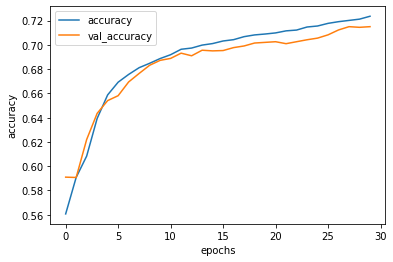

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

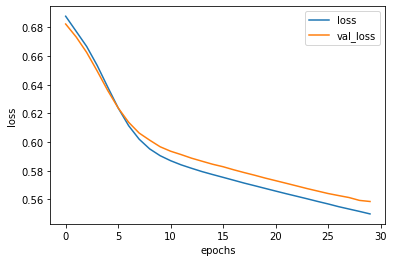

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

num_epochs = 150
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/150
719/719 [==============================] - 16s 16ms/step - loss: 0.6834 - accuracy: 0.5605 - val_loss: 0.6793 - val_accuracy: 0.5708
Epoch 2/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6746 - accuracy: 0.5753 - val_loss: 0.6706 - val_accuracy: 0.5907
Epoch 3/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6634 - accuracy: 0.6098 - val_loss: 0.6597 - val_accuracy: 0.6207
Epoch 4/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6497 - accuracy: 0.6388 - val_loss: 0.6474 - val_accuracy: 0.6349
Epoch 5/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6361 - accuracy: 0.6523 - val_loss: 0.6358 - val_accuracy: 0.6417
Epoch 6/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6253 - accuracy: 0.6586 - val_loss: 0.6273 - val_accuracy: 0.6468
Epoch 7/150
719/719 [==============================] - 10s 14ms/step - loss: 0.6174 - accuracy: 0.6641 - val_loss: 0.6207 - val_ac

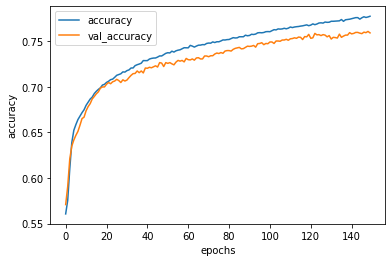

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

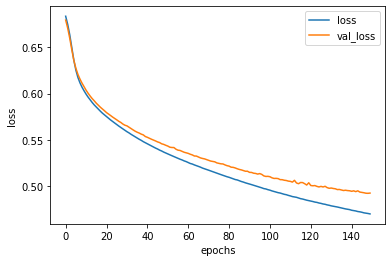

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [46]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
predictions = model.predict(padded)
print(predictions)

[[0.59354866]
 [0.08031139]
 [0.77666056]
 [0.83346194]]
